In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Data Presentation and Pre-Processing
Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *

#import os
#data_base_path = os.path.join(os.pardir, 'data')
#data_folder = 'train.csv'
#data_path = os.path.join(data_base_path, data_folder)
#y, tX, ids = load_csv_data(data_path)

from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Simple data description (change later)
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [ ]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000).

### Quick Pre-Processing

A faire d'après Robin: Dataprocessing: 
- Truc qui évalue les NA
- Fonction qui vire ou non un featues basé sur un seul
- Remplace les NA par la moyenne

In [3]:
from implementations_Chris_stand import *

Managing the meaningless values:

In [4]:
# putting the meaningless values to "nan"
tX0 = np.where(tX==-999, np.nan,tX) #nanmin nanstd

In [5]:
# OPTIONNAL: replaces the nan values by medians
med_X = np.nanmedian(tX, axis=0)
inds = np.where(np.isnan(tX))
tX[inds] = np.take(med_X, inds[1])

In [ ]:
# OPTIONNAL : keep only columns that do not have too much missing data
tX, rmX = train_data_formatting(tX, degree = 1, cutoff = 0.7, 
                      imputation = impute_median, interaction = False)

Managing outliers:

In [ ]:
# remove outliers based on the plots in the Exploratory analysis
y, tX = remove_outliers(y, tX, [0, 2, 3, 8, 13, 16, 19, 21, 23, 26],
                       [1100, 1000, 1000, 2500, 500, 500, 800, 1800, 800, 600])

Selecting a sub-sample of training test

In [ ]:
#OPTIONNAL
n0 = 20000
n = 10000
tX = tX[n0:n0+n]
y = y[n0:n0+n]
ids = ids[n0:n0+n]
print("tX shape={tXs}\n y shape={ys}\n ids shape={ids}".format(tXs=tX.shape, ys=y.shape, ids=ids.shape))

Managing categorical data:

In [ ]:
# OPTIONNAL: remove categorical data
tX = np.delete(tX, 22, axis=1)

In [6]:
# Creating 3 jet collection for three categories 
idx0, y_jet0, tX_jet0, idx1, y_jet1, tX_jet1, idx2, y_jet2, tX_jet2 = separate_jet(y, tX)

tX_jet0 = np.delete(tX_jet0, 22, axis=1)
tX_jet1 = np.delete(tX_jet1, 22, axis=1)
tX_jet2 = np.delete(tX_jet2, 22, axis=1)
tX_jet0, rmX_jet0 = train_data_formatting(tX_jet0, degree = 1, cutoff = 0.95, 
                      imputation = impute_median, interaction = False)
tX_jet1, rmX_jet1 = train_data_formatting(tX_jet1, degree = 1, cutoff = 0.95, 
                      imputation = impute_median, interaction = False)
tX_jet2, rmX_jet2 = train_data_formatting(tX_jet2, degree = 1, cutoff = 0.95, 
                      imputation = impute_median, interaction = False)
rmX_jet0 = np.append(rmX_jet0, 22)
rmX_jet1 = np.append(rmX_jet1, 22)
rmX_jet2 = np.append(rmX_jet2, 22)

#Standardization of tX
tX_jet0 = np.apply_along_axis(standardize, 1, tX_jet0)
tX_jet1 = np.apply_along_axis(standardize, 1, tX_jet1)
tX_jet2 = np.apply_along_axis(standardize, 1, tX_jet2)

In [7]:
print("tX shape={tXs}\ntX_jet0 shape={tX0s}\ntX_jet1 shape={tX1s}\ntX_jet2+ shape={tX2s}".format(
    tXs=tX.shape, tX0s=tX_jet0.shape, tX1s=tX_jet1.shape, tX2s=tX_jet2.shape))

tX shape=(250000, 30)
tX_jet0 shape=(99913, 19)
tX_jet1 shape=(77544, 22)
tX_jet2+ shape=(72543, 29)


### Exploratory Analysis

In [ ]:
for f in [2, 6, 10, 15, 20, 27]:
    plot_feature(ids, tX0, y, f)

# Feature Processing

**Least squares**

In [ ]:
(w_ls, loss_ls) = least_squares(y, ntX)

print("w* ={w}\n\nmse={loss}".format(
    w=w_ls, loss=loss_ls))

**Least squares with Gradient Descent**

In [ ]:
#define parameters

initial_w = np.zeros(ntX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_gd = []
ws_gd = []
for gamma in gammas:
    (w, loss) = least_squares_GD(y, ntX, initial_w, max_iters, gamma)
    losses_gd.append(loss)
    ws_gd.append(w)

In [ ]:
#plot the losses per gamma

fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [ ]:
idx = np.argmin(losses_gd)

loss_gd = losses_gd[idx]
w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=loss_gd, gamma=gamma_gd ))

**Least squares with Stochastic Gradient Descent**

In [ ]:
initial_w = np.zeros(ntX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_sgd = [None] * len(gammas)
ws_sgd = [None] * len(gammas)
for g in range(len(gammas)):
    (ws_sgd[g], losses_sgd[g]) = least_squares_SGD(y, ntX, initial_w, max_iters, gammas[g])

In [ ]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [ ]:
idx = np.argmin(losses_sgd)

loss_sgd = losses_sgd[idx]
w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=ws_sgd[-1], loss=loss_sgd, gamma = gamma_sgd))

**Ridge regression**

*Cross-validation hyperparameter selection*

In [ ]:
seed = 1
degree = 2
k_fold = 4
lambdas = np.logspace(-15, -1, 50)

In [ ]:
my = y[0:20000]
mtX = ntX[0:20000, :]

In [ ]:
k_indices = build_k_indices(my, k_fold, seed)

rmse_tr_cv = []
rmse_te_cv = []

for lambda_ in  lambdas:
    l_rmse_tr = []
    l_rmse_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation(my, mtX, k_indices, k, lambda_, degree)
        l_rmse_tr.append(np.sqrt(2*loss_tr))
        l_rmse_te.append(np.sqrt(2*loss_te))
    rmse_tr_cv.append(np.mean(l_rmse_tr))
    rmse_te_cv.append(np.mean(l_rmse_te))
cross_validation_visualization(lambdas, rmse_tr_cv, rmse_te_cv)

In [ ]:
idx = np.argmin(rmse_te_cv)
lambda_ri = lambdas[idx]

print("lambda* ={lambda_}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, rmse_tr=rmse_tr_cv[idx], rmse_te=rmse_te_cv[idx]))

*Bias-variance decomposition for complexity determination*

In [ ]:
seeds = range(10)
ratio_train = 0.7
degrees = range(1, 12)

rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(mtX, my, ratio_train, seed)        
        
    mse_tr = []
    mse_te = []
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = least_squares(y_tr, tx_tr)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_tr))
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_te))

bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

In [ ]:
poly = build_poly(mtX, 7)
print(poly.shape)

In [ ]:
seeds = range(10)
ratio_train = 0.7

x_tr, x_te, y_tr, y_te = split_data(mtX, my, ratio_train, seed)

In [ ]:
print(x_tr.shape)

In [ ]:
idx = np.argmin(rmse_te_cv)
degree_ri = degrees[idx]

print("degree* ={dergee}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    degree=degree_ri, rmse_tr=rmse_tr_bv[idx], rmse_te=rmse_te_bv[idx]))

### OTHERS
Cross-validation hyperparameter selection

In [ ]:
seed = 1
degree_ri = 7
k_fold = 4
lambdas = np.logspace(-12, -8, 10)
degrees = range(10, 13)

k_indices = build_k_indices(y, k_fold, seed)

rmse_tr_ri, rmse_te_ri = cross_validation(y, tX, k_indices, k_fold, degrees, lambdas, ml_function = 'ri', max_iters = 100, gamma = 0.05, verbose = False)

In [ ]:
cross_validation_visualization(degrees, rmse_tr_ri, rmse_te_ri, lambdas)

In [ ]:
idx = np.unravel_index(np.nanargmin(rmse_te_ri), rmse_te_ri.shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx]))

(Bias-variance decomposition for complexity determination)

### Logistic regression

idx0, y_jet0, tX_jet0
idx1, y_jet1, tX_jet1
idx2, y_jet2, tX_jet2

In [8]:
def binarization(y_non_binary):
    """returns a binary [0,1] list from a binary [-1.0,1.0] list (-1.0->0 and 1.0->1)"""
            
    y_binary = np.where(y_non_binary==-1.0, 0, 1)
    return y_binary

def check_binary(y):
    for i in y:
        if (i != 0) and (i != 1):
            print("y value is non-binary !!!")
            print(i)

In [9]:
def logistic_regressionS(idx, y, tX, max_iters, gammas):
    
    initial_w = np.zeros(tX.shape[1])
    losses_lr = np.empty(len(gammas))
    ws_lr = np.empty((len(gammas), len(initial_w)))
    
    for idx, gamma in enumerate(gammas):
        (ws_lr[idx, :], losses_lr[idx]) = logistic_regression(y, tX, initial_w, max_iters, gamma)
        
    #plot the losses per gamma used
    fig, ax = plt.subplots()
    ax.semilogx(gammas, losses_lr)
    ax.set(xlabel='gamma', ylabel='normalized loss', title='Loss per choice of learning rate')
    ax.grid()
    plt.show()
    
    idx = np.nanargmin(losses_lr)
    w_lr = ws_lr[idx]
    gamma_lr = gammas[idx]
    print("w* ={w}\n\nloss ={loss}\n\ngamma={gamma}".format(w=w_lr, loss=losses_lr[idx], gamma = gamma_lr))
    
    return w_lr, losses_lr, gamma_lr

C:\Users\wendl\Documents\GitHub\Machine-learning-Project-2019\scripts\implementations_Chris_stand.py:229: RuntimeWarning: divide by zero encountered in log
  loss -= y[n]*np.log(h)+(1-y[n])*np.log(1-h)
C:\Users\wendl\Documents\GitHub\Machine-learning-Project-2019\scripts\implementations_Chris_stand.py:229: RuntimeWarning: invalid value encountered in multiply
  loss -= y[n]*np.log(h)+(1-y[n])*np.log(1-h)


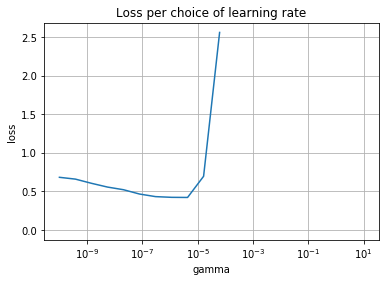

w* =[ -396712.85152998 -1799714.84342767 -1010843.49266186  -153302.03567731
   662376.25578737  -153302.10127843   714840.93360389   156250.44004254
   633282.81326952  1291571.37747249   283636.42728518   185171.72651376
  -340047.62483274   312537.13256488   274980.73100722  -382806.7450548
    98712.49857209  -613312.45155087   236681.80989189]

loss =0.0

gamma=10.0


KeyboardInterrupt: 

In [10]:
max_iters=1000
gammas = np.logspace(-10, 1, 20)

y_jet0_b = binarization(y_jet0)
#check_binary(y_jet0_b)
y_jet1_b = binarization(y_jet1)
#check_binary(y_jet1_b)
y_jet2_b = binarization(y_jet2)
#check_binary(y_jet2_b)

w_lr_0, losses_lr_0, gamma_lr_0 = logistic_regressionS(idx0, y_jet0_b, tX_jet0, max_iters, gammas)
w_lr_1, losses_lr_1, gamma_lr_1 = logistic_regressionS(idx1, y_jet1_b, tX_jet1, max_iters, gammas)
w_lr_2, losses_lr_2, gamma_lr_2 = logistic_regressionS(idx2, y_jet2_b, tX_jet2, max_iters, gammas)

In [ ]:
a = sigmoid(((tX_jet0[254]).T).dot(w_lr_0))
if (a==0):
    print("yes")
else:
    print("no")
np.log(a)

In [ ]:
float(2)

***Cross-validation for hyperparameter determination***

In [13]:
def cross_validation_logistic_regressionS(y, tX, k_fold, degrees, gamma_lr, max_iters):
    seed = 1
    k_indices = build_k_indices(y, k_fold, seed)

    loss_tr_lr, loss_te_lr = cross_validation(y, tX, k_indices, k_fold, degrees, 
                                          lambdas=[0], ml_function = 'lr', max_iters = 1000, gamma = gamma_lr)
    cross_validation_visualization(degrees, loss_tr_lr, loss_te_lr)
    
    loss_te_lr = np.array(loss_te_lr)
    loss_tr_lr = np.array(loss_tr_lr)
    #idx = np.nanargmin(loss_te_lr) #indices of the minimum values ignoring NaNs
    idx = np.nanargmin(loss_te_lr) 
    # ---> on ne doit pas prendre l'indice du min loss du TRAINING (et pas testing) ?
    degree_lr = degrees[idx]

    print("degree*={degree}\nloss train={loss_tr}\nloss test={loss_te}\n".format(
        degree=degree_lr, loss_tr=loss_tr_lr.flatten()[idx], loss_te=loss_te_lr.flatten()[idx]))
    return degree_lr, loss_te_lr, loss_tr_lr

In [ ]:
k_fold = 4
degrees = range(0, 9)

degree_lr_0, loss_te_lr_0, loss_tr_lr_0 = cross_validation_logistic_regressionS(y_jet0_b, tX_jet0, k_fold, degrees, gamma_lr_0, max_iters)
degree_lr_1, loss_te_lr_1, loss_tr_lr_1 = cross_validation_logistic_regressionS(y_jet1_b, tX_jet1, k_fold, degrees, gamma_lr_1, max_iters)
degree_lr_2, loss_te_lr_2, loss_tr_lr_2 = cross_validation_logistic_regressionS(y_jet2_b, tX_jet2, k_fold, degrees, gamma_lr_2, max_iters)

### Regularized logistic regression

In [ ]:
initial_w = np.zeros(tX.shape[1])
max_iters = 1000
gammas = np.logspace(-10, -1, 20)
lambda_rlr =lambda_ri

In [ ]:
losses_rlr = np.empty(len(gammas))
ws_rlr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = reg_logistic_regression(y, tX, lambda_rlr, initial_w, max_iters, gamma)
    losses_rlr[idx] = loss
    ws_rlr[idx, :] = w

In [ ]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_rlr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [ ]:
idx = np.nanargmin(losses_rlr)

w_rlr = ws_rlr[idx]
gamma_rlr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_rlr, loss=losses_rlr[idx], gamma = gamma_rlr))

In [ ]:
***Cross-validation hyperparameter selection***

In [ ]:
seed = 1
degree_rlr = 1
k_fold = 4
lambdas = np.logspace(-8, -2, 10)
degrees = range(3, 12)

k_indices = build_k_indices(y, k_fold, seed)

In [ ]:
loss_tr_rlr, loss_te_rlr = cross_validation(y, tX, k_indices, k_fold, degrees, 
                                          lambdas, ml_function = 'rlr', max_iters = 500, gamma = gamma_rlr)

In [ ]:
cross_validation_visualization(degrees, loss_tr_rlr, loss_te_rlr, lambdas)

In [ ]:
idx = np.unravel_index(np.nanargmin(loss_te_rlr), loss_te_rlr.shape)
lambda_rlr = lambdas[idx[0]]
degree_rlr = degrees[idx[1]]

print("lambda* ={lambda_}n\ndegree*={degree}\n\nloglikelihood train={log_tr}\n\nloglikelihood test={log_te}".format(
    lambda_=lambda_rlr, degree=degree_rlr, log_tr=loss_tr_rlr[idx], log_te=loss_te_rlr[idx]))

# Machine Learning

In [ ]:
from implementations import *

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)